# **BentoML Example: Image Segmentation with PaddleHub**
**BentoML makes moving trained ML models to production easy:**



*   Package models trained with any ML framework and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with adaptive micro-batching support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it adaptable to your infrastrcuture

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook demonstrates how to use BentoML to turn a paddlepaddle model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

The example is based on [this tutorial](https://www.paddlepaddle.org.cn/documentation/docs/en/1.5/beginners_guide/basics/fit_a_line/README.html), using dataset from the [UCI Machine Learning Repository](https://www.kaggle.com/schirmerchad/bostonhoustingmlnd)

This example notebook is base on the guide from PaddleHub: https://github.com/PaddlePaddle/PaddleHub/blob/release/v2.0/docs/docs_en/quick_experience/python_use_hub_en.md

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip3 install -q bentoml paddlepaddle paddlehub

In [3]:
!hub install deeplabv3p_xception65_humanseg

/home/chvu/.local/lib/python3.8/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/usr/share/python-wheels/html5lib-1.0.1-py2.py3-none-any.whl/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
[2021-04-23 23:47:19,039] [    INFO] - Module deeplabv3p_xception65_humanseg already installed in /home/chvu/.paddlehub/mod

## Prepare Input Data

In [4]:
!wget https://paddlehub.bj.bcebos.com/resources/test_image.jpg

--2021-04-23 23:47:23--  https://paddlehub.bj.bcebos.com/resources/test_image.jpg
Resolving paddlehub.bj.bcebos.com (paddlehub.bj.bcebos.com)... 103.235.46.61, 2409:8c00:6c21:10ad:0:ff:b00e:67d
Connecting to paddlehub.bj.bcebos.com (paddlehub.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 967120 (944K) [image/jpeg]
Saving to: ‘test_image.jpg.1’

test_image.jpg.1    100%[===================>] 944.45K   313KB/s    in 3.0s    

2021-04-23 23:47:29 (313 KB/s) - ‘test_image.jpg.1’ saved [967120/967120]



## Create BentoService with PaddleHub Module Instantiation

In [5]:
%%writefile paddlehub_service.py
import paddlehub as hub
import paddle
import bentoml
from bentoml import env, artifacts, api, BentoService, web_static_content
import imageio
from bentoml.adapters import ImageInput


@env(infer_pip_packages=True)
class PaddleHubService(bentoml.BentoService):
    def __init__(self):
      super(PaddleHubService, self).__init__()
      self.module = hub.Module(name="deeplabv3p_xception65_humanseg")

    @api(input=ImageInput(), batch=True)
    def predict(self, images):
        results = self.module.segmentation(images=images, visualization=True)
        return [result['data'] for result in results]


Overwriting paddlehub_service.py


In [6]:
# Import the custom BentoService defined above
from paddlehub_service import PaddleHubService
import numpy as np
import cv2

bento_svc = PaddleHubService()

/home/chvu/.local/lib/python3.8/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/usr/share/python-wheels/html5lib-1.0.1-py2.py3-none-any.whl/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
[2021-04-23 23:47:32,628] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init_

In [7]:
# Predict with the initialized module
image = cv2.imread("test_image.jpg")
images = [image]
segmentation_results = bento_svc.predict(images)

[WARNING 2021-04-23 23:48:05,357 image.py:721] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


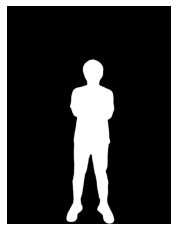

In [8]:
# Visualize the return data
from matplotlib import pyplot as plt

for result in segmentation_results:
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

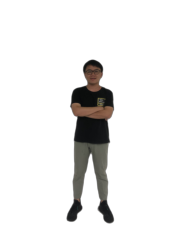

In [9]:
# Get the segmented image from the original image
for result, original in zip(segmentation_results, images):
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
    original_mod = cv2.cvtColor(original, cv2.COLOR_RGB2RGBA)
    mask = result / 255
    *_, alpha = cv2.split(mask)
    mask = cv2.merge((mask, alpha))
    segmented_image = (original_mod * mask).clip(0, 255).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGRA2RGBA))
    plt.axis('off')
    plt.show()

In [ ]:
# Start a dev model server to test out everything
bento_svc.start_dev_server()

In [ ]:
!curl -i \
  -F image=@test_image.jpg \
  localhost:5000/predict

In [ ]:
# Stop the dev model server
bento_svc.stop_dev_server()

In [10]:
# Save the BentoService for deployment
saved_path = bento_svc.save()

[2021-04-23 23:48:28,424] INFO - BentoService bundle 'PaddleHubService:20210423234828_2DF1FE' saved to: /home/chvu/bentoml/repository/PaddleHubService/20210423234828_2DF1FE


## REST API Model Serving

In [ ]:
!bentoml serve PaddleHubService:latest

If you are running this notebook from Google Colab, you can start the dev server with --run-with-ngrok option, to gain acccess to the API endpoint via a public endpoint managed by ngrok:

In [ ]:
!bentoml serve PaddleHubService:latest --run-with-ngrok

## Make request to the REST server

*After navigating to the location of this notebook, copy and paste the following code to your terminal and run it to make request*

In [ ]:
curl -i \
  --header "Content-Type: image/jpeg" \
  --request POST \
  --data-binary @test_image.jpg \
  localhost:5000/predict

## Launch inference job from CLI

In [ ]:
!bentoml run PaddleHubService:latest predict --input-file test_image.jpg

## Adding Custom Web Static Content 

In [ ]:
!curl https://raw.githubusercontent.com/bentoml/gallery/master/paddlehub/image-segmentation/static.tar.xz -o static.tar.xz
!tar --xz -xf static.tar.xz
!rm static.tar.xz

In [14]:
%%writefile paddlehub_service.py
import paddlehub as hub
import bentoml
from bentoml import env, artifacts, api, BentoService, web_static_content
from bentoml.adapters import ImageInput
import cv2
import imageio
import numpy as np

@env(infer_pip_packages=True)
@web_static_content('./static')
class PaddleHubService(bentoml.BentoService):
    def __init__(self):
      super(PaddleHubService, self).__init__()
      self.module = hub.Module(name="deeplabv3p_xception65_humanseg")

    @api(input=ImageInput(), batch=False)
    def test(self, image):
        results = self.module.segmentation(images=[image], visualization=True)
        
        # Post-processing to apply segmentation mask on original image
        segmentation_result = cv2.cvtColor(results[0]['data'], cv2.COLOR_GRAY2RGB)
        original_mod = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
        mask = segmentation_result / 255
        *_, alpha = cv2.split(mask)
        mask = cv2.merge((mask, alpha))
        segmented_image = (original_mod * mask).clip(0, 255).astype(np.uint8)
        return segmented_image

Overwriting paddlehub_service.py


In [15]:
# Import the custom BentoService defined above
from paddlehub_service import PaddleHubService

svc = PaddleHubService()
saved_path = svc.save()

[2021-04-23 23:50:04,066] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


[2021-04-23 23:50:09,070] INFO - BentoService bundle 'PaddleHubService:20210423235008_AB2ED0' saved to: /home/chvu/bentoml/repository/PaddleHubService/20210423235008_AB2ED0


In [17]:
!bentoml serve PaddleHubService:latest

[2021-04-23 23:50:45,194] INFO - Getting latest version PaddleHubService:20210423235008_AB2ED0
[2021-04-23 23:50:45,195] INFO - Starting BentoML API server in development mode..
/home/chvu/.local/lib/python3.8/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/usr/share/python-wheels/html5lib-1.0.1-py2.py3-none-any.whl/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprec

Visit http://localhost:5000/ to serve the custom UI below. Note that the swagger docs is still accessible through http://localhost:5000/docs.

![Custom UI](webui.png)

## Containerize model server with Docker

One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the PaddeHub prediction service created above:

In [ ]:
!bentoml containerize PaddleHubService:latest

In [ ]:
!docker run --rm -p 5000:5000 PaddleHubService:latest

# **Deployment Options**

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:

* [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
* [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
* [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:

* [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
* [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
* [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
* [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:

* [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
* [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
* [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
* [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
* [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)